In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm import tqdm

%matplotlib inline

PATH = '../'

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

Wall time: 2.59 s


<img src='desc.png'></img>

In [8]:
print(train.shape)
train.head()

(649912, 15)


,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [9]:
print(test.shape)
test.head()

(284071, 9)


,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01T00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01T01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01T01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [72]:
# Скорее всего взяли 300 рандомных спутников из трейна и поместили в тест, может быть важно для валидации

ltr, lte = len(train['sat_id'].unique()), len(test['sat_id'].unique())
print(f'Unique satellites in train {ltr}')
print(f'Unique satellites in train {lte}')

Unique satellites in train 600
Unique satellites in train 300


## Observations EDA

### Num observations for each satellite

Min observations: 94 for satellite 252, Max observations: 6320  for satellite 372
Mean: 1083.1866666666667




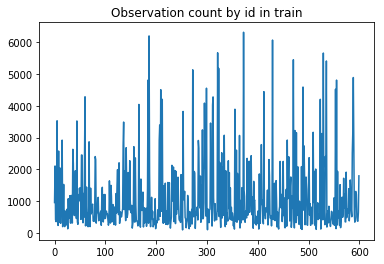

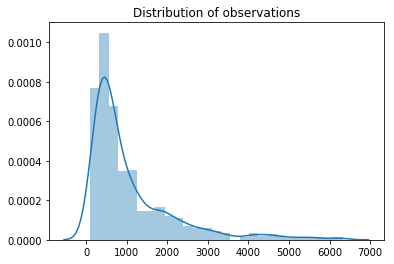

In [68]:
ids, obs = train.groupby('sat_id').count().iloc[:, 0].index, train.groupby('sat_id').count().iloc[:, 0].values
print(f'Min observations: {min(obs)} for satellite {ids[np.argwhere(obs == min(obs))][0][0]}, Max observations: {max(obs)}  for satellite {ids[np.argwhere(obs == max(obs))][0][0]}')
print(f'Mean: {np.mean(obs)}\n\n')
plt.title('Observation count by id in train');
plt.plot(ids, obs);
plt.show();

plt.title('Distribution of observations')
sns.distplot(obs)
plt.show()

Min observations: 84 for satellite 252, Max observations: 5707  for satellite 372
Mean: 946.9033333333333




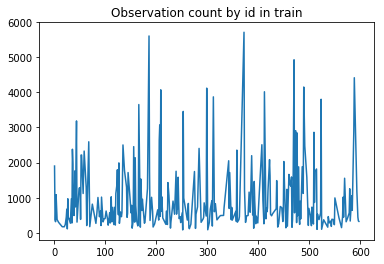

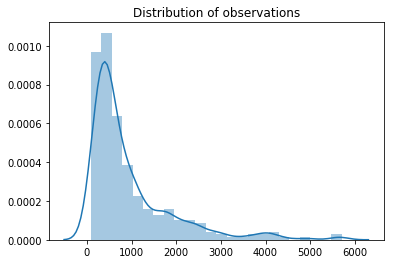

In [69]:
ids, obs = test.groupby('sat_id').count().iloc[:, 0].index, test.groupby('sat_id').count().iloc[:, 0].values
print(f'Min observations: {min(obs)} for satellite {ids[np.argwhere(obs == min(obs))][0][0]}, Max observations: {max(obs)}  for satellite {ids[np.argwhere(obs == max(obs))][0][0]}')
print(f'Mean: {np.mean(obs)}\n\n')
plt.title('Observation count by id in train');
plt.plot(ids, obs);
plt.show();

plt.title('Distribution of observations')
sns.distplot(obs)
plt.show()

### Delta observations for common satellites in train & test

In [91]:
trainTestSatellites = train['sat_id'].unique()[[True if sat_id in test['sat_id'].unique() else False for sat_id in train['sat_id'].unique()]]
trainTestData = train.loc[[True if sat_id in trainTestSatellites else False for sat_id in train['sat_id'].values], :]

In [100]:
deltaObs = np.abs(trainTestData.groupby('sat_id').count().iloc[:,0] - test.groupby('sat_id').count().iloc[:,0])
print(f'Mean delta between train and test: {np.mean(deltaObs)}')
print(f'Max delta between train and test: {np.max(deltaObs)}')
print(f'Min delta between train and test: {np.min(deltaObs)}')

Mean delta between train and test: 103.70666666666666
Max delta between train and test: 613
Min delta between train and test: 10


### Time gap between observations for one satellite

Для разных спутников дельта разная, но для одного и того же спутника в трейне и тесте дельта одна и та же

In [132]:
ID = np.random.choice(train['sat_id'].unique(), 1)[0]
dataTrain = train[train['sat_id'] == ID]
deltaTsTrain = []
for idx in range(1, dataTrain.shape[0]):
    delta = pd.to_datetime(dataTrain['epoch'].iloc[idx]) - pd.to_datetime(dataTrain['epoch'].iloc[idx-1])
    deltaTsTrain.append(delta)
print(f'Delta between 2 observations for satellite {ID} in Train is {deltaTsTrain[0]}')

if ID in test['sat_id'].unique():
    dataTest = test[test['sat_id'] == ID]
    deltaTsTest = []
    for idx in range(1, dataTest.shape[0]):
        delta = pd.to_datetime(dataTest['epoch'].iloc[idx]) - pd.to_datetime(dataTest['epoch'].iloc[idx-1])
        deltaTsTest.append(delta)
    print(f'Delta between 2 observations for satellite {ID} in Test is {deltaTsTest[0]}')
else:
    print('ID not present')

Delta between 2 observations for satellite 113 in Train is 0 days 02:08:42.619000
Delta between 2 observations for satellite 113 in Test is 0 days 02:08:42.619000


Зависит ли количество данных для спутника от дельты?

In [136]:
results = []
for ID in tqdm(train['sat_id'].unique()): 
    dataTrain = train[train['sat_id'] == ID]
    deltaTsTrain = []
    for idx in range(1, dataTrain.shape[0]):
        delta = pd.to_datetime(dataTrain['epoch'].iloc[idx]) - pd.to_datetime(dataTrain['epoch'].iloc[idx-1])
        deltaTsTrain.append(delta)
    results.append([ID, deltaTsTrain[0], len(deltaTsTrain)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 600/600 [02:47<00:00,  3.43it/s]


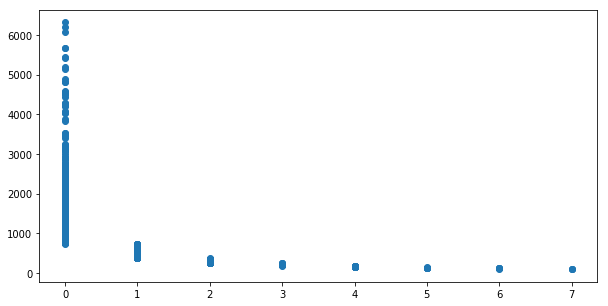

In [186]:
hours = []
for res in results:
    hours.append(int(str(res[1]).split(':')[0].split(' ')[-1]))
plt.figure(figsize = (10,5))
plt.scatter(hours, pd.DataFrame(results).iloc[:, -1].values)
plt.show()

In [191]:
for val in np.unique(hours):
    print(f'Mean observations: {np.mean(pd.DataFrame(results).iloc[:, -1].values[hours == val])} Gap: {val} hours')

Mean observations: 1883.4595588235295 Gap: 0 hours
Mean observations: 530.6958762886597 Gap: 1 hours
Mean observations: 311.05333333333334 Gap: 2 hours
Mean observations: 219.6551724137931 Gap: 3 hours
Mean observations: 168.2 Gap: 4 hours
Mean observations: 134.85714285714286 Gap: 5 hours
Mean observations: 118.0 Gap: 6 hours
Mean observations: 100.0 Gap: 7 hours


Делаем вывод, что зависит. Чем больше наблюдений для спутника, тем длиннее геп между снимками.
! Стоит помнить что я тут не учитываю дни, возможно у некоторых спутников геп больше дня.

Все это я проверяю в надежде что от гепа и кол-ва наблюдений как-то зависит траектория полета (орбита там или еще что)

In [192]:
gc.collect()

13623

## Satellite movement EDA

Визуализируем движение одного спутника по орбите

In [165]:
ID = np.random.choice(train['sat_id'].unique(), 1)[0]
ID = 57
data = train[train['sat_id'] == ID].reset_index(drop = True)
print(f'ID: {ID}, Total observations: {data.shape[0]}')

ID: 57, Total observations: 1241


In [166]:
import plotly.express as px
import plotly.graph_objects as go

In [167]:
'''
Фичи по реальным меткам из трейна
Ошибки между real и simulated для конкретного спутника
Может быть как-то классифицировать ошибки
Может быть вообще не исправлять более или менее точные примеры
'''

'\nФичи по реальным меткам из трейна\nОшибки между real и simulated для конкретного спутника\nМожет быть как-то классифицировать ошибки\nМожет быть вообще не исправлять более или менее точные примеры\n'

In [168]:
x,y,z = data.loc[:, 'x'].values, data.loc[:, 'y'].values, data.loc[:, 'z'].values
xSim,ySim,zSim = data.loc[:, 'x_sim'].values, data.loc[:, 'y_sim'].values, data.loc[:, 'z_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        color='rgb(127, 127, 127)',
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')
fig = go.Figure(data = [fig1, fig2])
fig.show()

Визуализируем появление точек динамически

In [169]:
frames = []
x,y,z = [], [], []
framesTot = 100
for point in range(0, data.shape[0])[:framesTot]:
    if point == 0:
        x,y,z = [data.loc[point, 'x']], [data.loc[point, 'y']], [data.loc[point, 'z']]
    else:
        x.append(data.loc[point, 'x']), y.append(data.loc[point, 'y']), z.append(data.loc[point, 'z'])
        frames.append(go.Frame(data=[go.Scatter3d(x=x, y=y, z=z)]))
        
        
# frames_sim = []
# x_sim,y_sim,z_sim = [], [], []
# for point in range(0, data.shape[0])[:framesTot]:
#     if point == 0:
#         x_sim,y_sim,z_sim = [data.loc[point, 'x_sim']], [data.loc[point, 'y_sim']], [data.loc[point, 'z_sim']]
#     else:
#         x_sim.append(data.loc[point, 'x_sim']), y_sim.append(data.loc[point, 'y_sim']), z_sim.append(data.loc[point, 'z_sim'])
#         frames_sim.append(go.Frame(data=[go.Scatter3d(x=x_sim, y=y_sim, z=z_sim)]))
    
fig = go.Figure(
    data=[go.Scatter3d(x = [x[0]], y=[y[0]], z = [z[0]],
                      marker=dict(
                        color='rgb(127, 127, 127)',
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')],
    layout=go.Layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    ),
    frames=frames
)


fig.update_layout(scene=dict(
    xaxis=dict(nticks=4, range=[-200000, 200000],),
    yaxis=dict(nticks=4, range=[-200000, 200000],),
    zaxis=dict(nticks=4, range=[-200000, 200000],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10),
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None])])]
)
fig.show()

Советую потыкаться в графики выше с разными айдишниками, очень познавательно

## Features EDA

Поиграемся с нормами

Норма вектора реальных координат, трейн:


In [170]:
print(f'ID: {ID}, Total observations: {data.shape[0]}')

ID: 57, Total observations: 1241


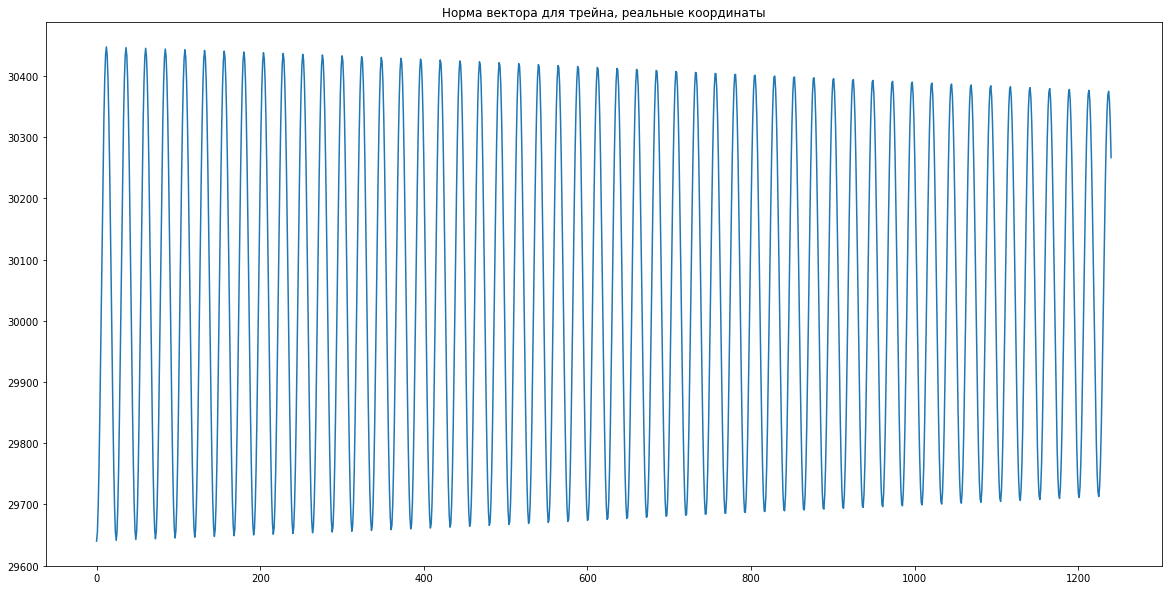

In [171]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма вектора для трейна, реальные координаты')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))

Норма вектора симулированных координат, трейн и тест

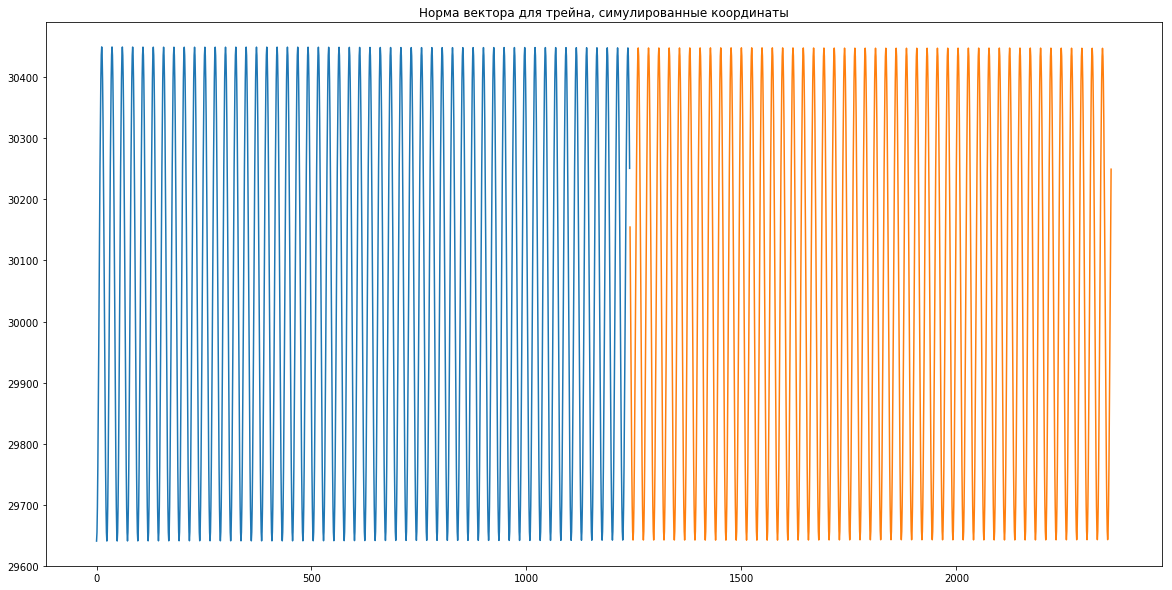

In [172]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
satDataTest = test[test['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
plt.figure(figsize = (20,10))
plt.title('Норма вектора для трейна, симулированные координаты')
plt.plot(np.arange(len(satDataTrain)), np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.arange(len(satDataTrain), len(satDataTrain) + len(satDataTest)), np.linalg.norm(satDataTest, axis = 1))

Норма вектора скорости, трейн:

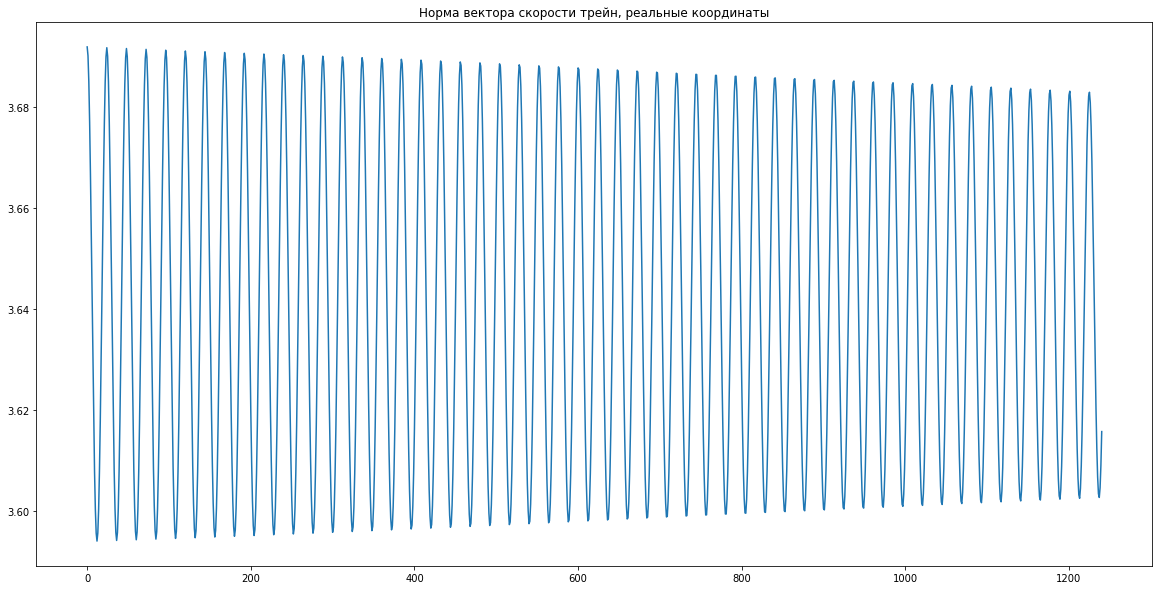

In [173]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['Vx', 'Vy', 'Vz']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма вектора скорости трейн, реальные координаты')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))

Норма вектора скорости симулированной, трейн и тест

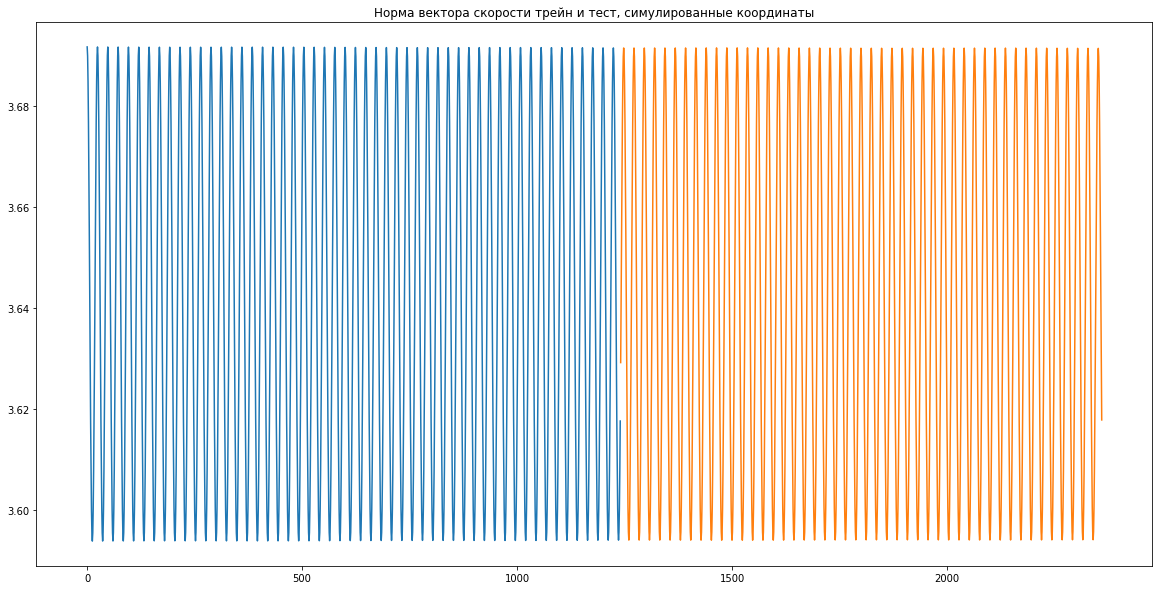

In [174]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['Vx_sim', 'Vy_sim', 'Vz_sim']]
satDataTest = test[test['sat_id'] == SAT_ID].loc[:, ['Vx_sim', 'Vy_sim', 'Vz_sim']]
plt.figure(figsize = (20,10))
plt.title('Норма вектора скорости трейн и тест, симулированные координаты')
plt.plot(np.arange(len(satDataTrain)), np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.arange(len(satDataTrain), len(satDataTrain) + len(satDataTest)), np.linalg.norm(satDataTest, axis = 1))

Норма симулированного вектора координат против реальных

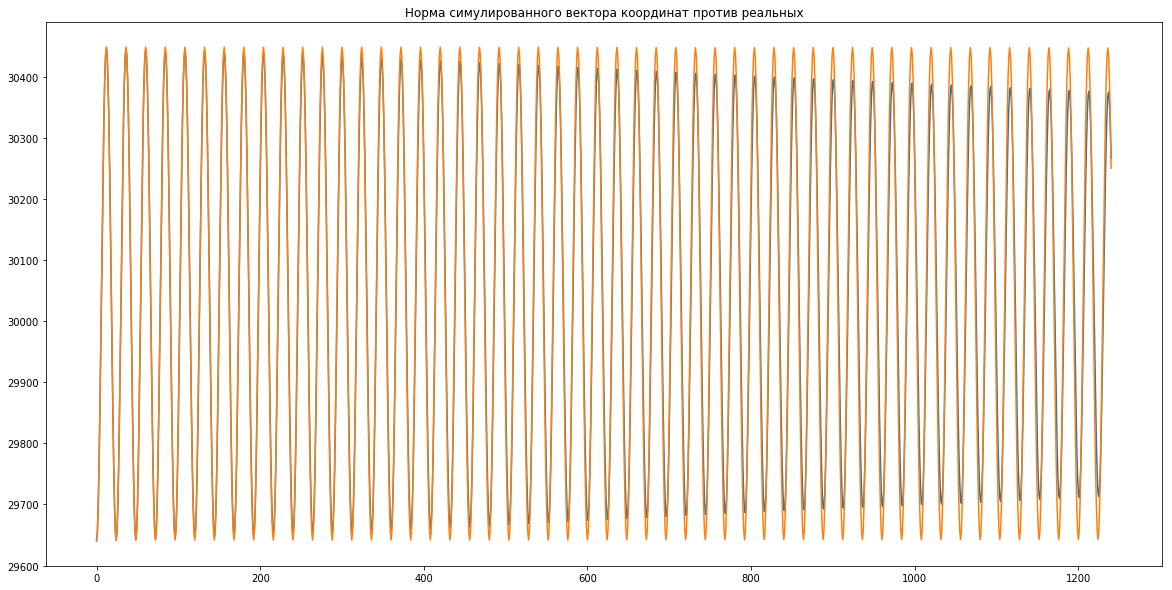

In [175]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма симулированного вектора координат против реальных')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))
plt.plot(np.linalg.norm(satDataTrainSim, axis = 1))

Норма дельты между реальностью и симуляцией

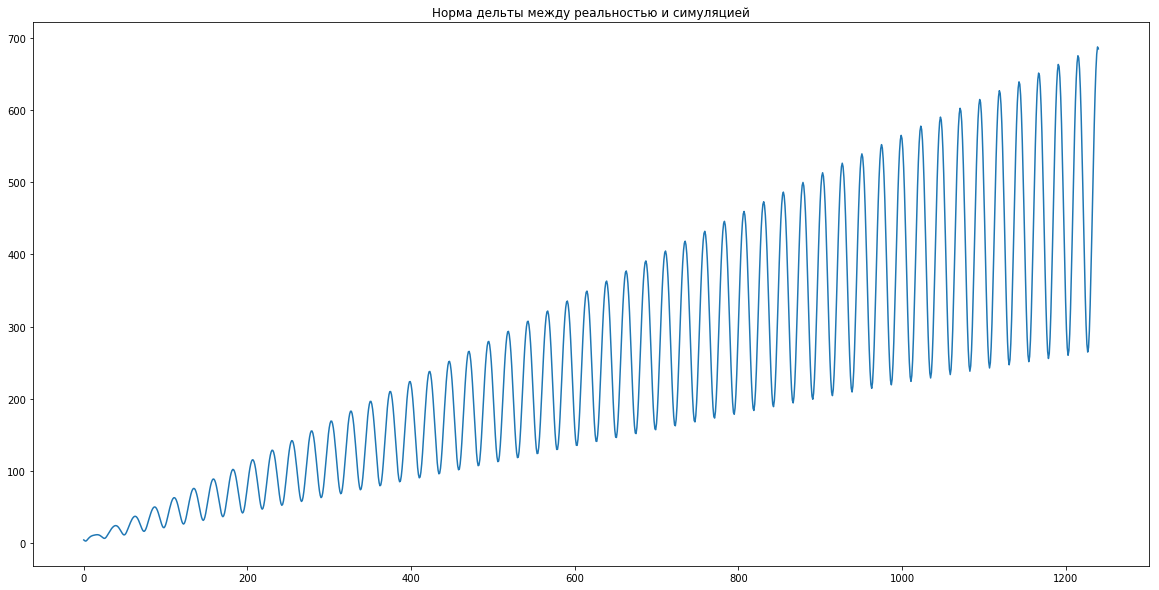

In [176]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))

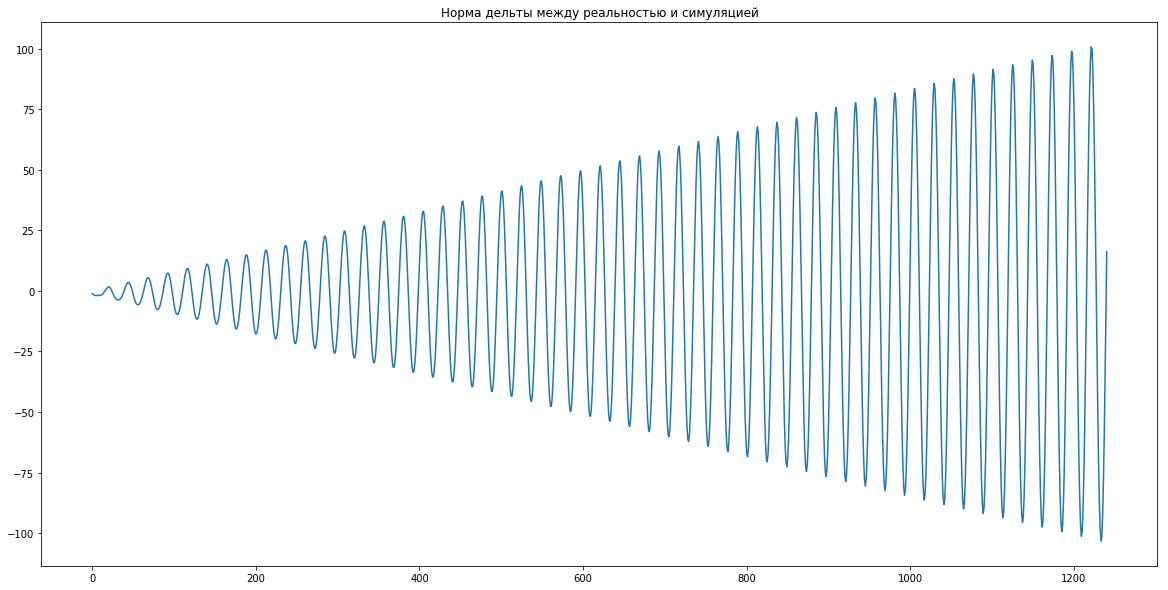

In [177]:
SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Дельта норм между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values, axis = 1) - np.linalg.norm(satDataTrainSim.values, axis = 1))

In [178]:
train

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237
5,5,2014-01-01T03:53:35.002,0,-3708.453525,-34767.115528,-7863.224747,1.136613,-1.651984,2.660079,-3726.986435,-34749.558551,-7921.459045,1.133861,-1.655467,2.659121
6,6,2014-01-01T04:40:18.003,0,-437.699227,-38249.612548,-234.351187,1.183619,-0.846348,2.752309,-463.278088,-38241.966025,-293.331552,1.181359,-0.849775,2.752681
7,7,2014-01-01T05:27:01.003,0,2863.147037,-39594.503233,7420.538280,1.162076,-0.128606,2.687907,2831.900642,-39595.997138,7364.088245,1.160316,-0.131566,2.689303
8,8,2014-01-01T06:13:44.004,0,6031.593902,-39056.319613,14731.102545,1.091816,0.497608,2.512783,5996.014434,-39065.326088,14679.572942,1.090515,0.495341,2.514879
9,9,2014-01-01T07:00:27.004,0,8950.655291,-36886.362968,21432.111677,0.985854,1.036692,2.256930,8911.952800,-36900.814799,21387.028371,0.984956,1.035218,2.259425


In [9]:
def changeCoords(coords):
    x, y, z = coords
    r = np.sqrt(np.sum(coords)**2)
    teta = np.arctan(np.sqrt(np.sum([x, y])**2)/z)
    phi = np.arctan(y/x)
    return r, teta, phi

In [10]:
changeCoords(train[train['sat_id'] == 0].iloc[0, 3:6].values)

(16466.396949400252, -0.20278390553994197, -0.9769774151516585)